In [ ]:
!pip install fastapi uvicorn torch torchvision seaborn

In [ ]:
# Importar bibliotecas necessárias
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
# Carregar o conjunto de dados FashionMNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [ ]:
# Criar DataLoaders para o conjunto de dados
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Definir a arquitetura da rede neural
class FashionMNISTModel(nn.Module):
    def __init__(self):
        super(FashionMNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.conv2(x)
        x = nn.ReLU(inplace=True)(x)
        x = nn.MaxPool2d(2)(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = nn.LogSoftmax(dim=1)(x)
        return output

In [ ]:
# Inicializar o modelo, otimizador e função de perda
model = FashionMNISTModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

Epoch [1/10], Validation Accuracy: 88.36%
Epoch [2/10], Validation Accuracy: 90.61%
Epoch [3/10], Validation Accuracy: 91.20%
Epoch [4/10], Validation Accuracy: 91.80%
Epoch [5/10], Validation Accuracy: 92.03%
Epoch [6/10], Validation Accuracy: 92.26%
Epoch [7/10], Validation Accuracy: 92.51%
Epoch [8/10], Validation Accuracy: 92.56%
Epoch [9/10], Validation Accuracy: 92.48%
Epoch [10/10], Validation Accuracy: 92.24%


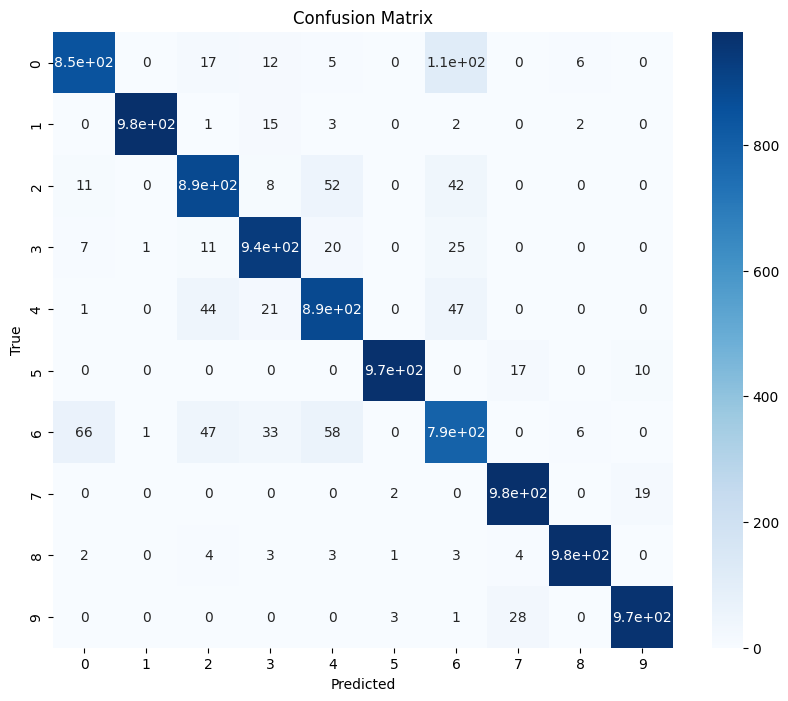

[[848   0  17  12   5   0 112   0   6   0]
 [  0 977   1  15   3   0   2   0   2   0]
 [ 11   0 887   8  52   0  42   0   0   0]
 [  7   1  11 936  20   0  25   0   0   0]
 [  1   0  44  21 887   0  47   0   0   0]
 [  0   0   0   0   0 973   0  17   0  10]
 [ 66   1  47  33  58   0 789   0   6   0]
 [  0   0   0   0   0   2   0 979   0  19]
 [  2   0   4   3   3   1   3   4 980   0]
 [  0   0   0   0   0   3   1  28   0 968]]


In [ ]:
# Treinar o modelo
num_epochs = 10
for epoch in range(num_epochs):
    # Treinar o modelo
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Avaliar o modelo no conjunto de validação
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {100 * correct / total:.2f}%')

# Salvar o modelo treinado
torch.save(model.state_dict(), 'fashion_mnist_model.pth')

# Plotar a matriz de confusão
model.eval()
results = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        results.extend(zip(labels, predicted))

y_true, y_pred = zip(*results)
y_true = list(y_true)
y_pred = list(y_pred)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Imprimir a matriz de confusão
print(cm)


In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
import torch
from torchvision import transforms

app = FastAPI()

# Carregar o modelo treinado
model = FashionMNISTModel()
model.load_state_dict(torch.load('fashion_mnist_model.pth'))
model.eval()

# Definir o schema de entrada
class PredictionRequest(BaseModel):
    image: list[list[list[float]]]

# Definir o endpoint de previsão
@app.post("/model/prediction")
def predict(request: PredictionRequest):
    # Pré-processar a imagem de entrada
    image = torch.tensor(request.image).unsqueeze(0).permute(0, 3, 1, 2)
    image = transforms.Normalize((0.1307,), (0.3081,))(image)

    # Fazer a previsão usando o modelo
    output = model(image)
    _, predicted = torch.max(output, 1)

    # Retornar a previsão
    return {"prediction": int(predicted.item())}